<h2>MSBA 326 Predictive Analytics and Machine Learning</h2>
<h3>Final Project: Instacart Market Basket Analysis</h3>
<h4>Which Products will an Instacart consumer purchase again?</h4>
<h5>Instacart Exploratory Data Analysis</h5>

## Introduction

Over a year ago, Instacart challenged the Kaggle community to use this anonymized data on
customer orders over time to predict which previously purchased products will be in a user’s next
order.

#### About the Data
The dataset for this competition is a relational set of files describing customers' orders over time.
The goal of the competition is to predict which products will be in a user's next order. The dataset is
anonymized and contains a sample of over 3 million grocery orders from more than 200,000
Instacart users. For each user, Instacart has provided between 4 and 100 of their orders, with the sequence of
products purchased in each order. The data also contains the week and hour of day the order was placed,
and a relative measure of time between orders. 

The data set was accessed from https://www.instacart.com/datasets/grocery-shopping-2017

The data dictionary can be found here: [Project Repository](https://github.com/Keareys/instacart/blob/master/analysis/data_description.md)

In [2]:
# DataViz imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

from IPython.display import Image
from IPython.core.display import HTML

import os, glob

# Selection, Data Processing
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

# ML Models
#import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

# ML Metrics
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import time
from collections import Counter

# Utilities
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore') # Ignore all warnings

### Data Loading and Initial Exploration
There are 6 tables in the data set.  We will import each table, set the data types for the fields that we will use and preview the data, including its shape.

In [2]:
# Small Tables
aisles_df = pd.read_csv('data/aisles.csv')
departments_df = pd.read_csv('data/departments.csv')
products_df = pd.read_csv('data/products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])

In [3]:
# Large Tables
train_df = pd.read_csv('data/order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

orders_df = pd.read_csv('data/orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

priors_df = pd.read_csv('data/order_products__prior.csv',dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

**Aisles**

In [4]:
print('aisles_df shape:',aisles_df.shape)
aisles_df.head(5)

aisles_df shape: (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


**Departments**

In [5]:
print('departments_df shape:',departments_df.shape)
departments_df.head(5)

departments_df shape: (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


**Products**

In [6]:
print('products_df shape:',products_df.shape)
products_df.head(5)

products_df shape: (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


**Orders**

In [7]:
print('orders_df shape:',orders_df.shape)
orders_df.head(5)

orders_df shape: (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
orders_df['eval_set'].unique()

[prior, train, test]
Categories (3, object): [prior, train, test]

**Train Orders**

In [9]:
print('train shape:',train_df.shape)
train_df.head(5)

train shape: (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


**Prior Orders**

In [10]:
print('priors_df shape:',priors_df.shape)
priors_df.head(5)

priors_df shape: (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


#### Data Description

**Orders Table**
The order table reports orders placed for a specific product or group of products.  It includes an identifier for the user, their respective orders, the day of week for each order, the hour of day for each order and the number of days since the last order was placed by this user id.  This table is the key table in the dataset.


**Order Products**
The order products table contains a relationship to orders and products, and includes reordered products. Given the problem statement, this table will be used to split the features into test and train sets.  

**Products/ Aisle/ Department**
These tables contain data to assist in the classification of products.  Its possible that these tables can be used to cluster the different products, however, the aisle and department tables are not that important in this data.

So, for each given order, we need to know the user_id, order_dow, days_since_prior and order_hour_of_day.

**Entity Relationship Diagram**

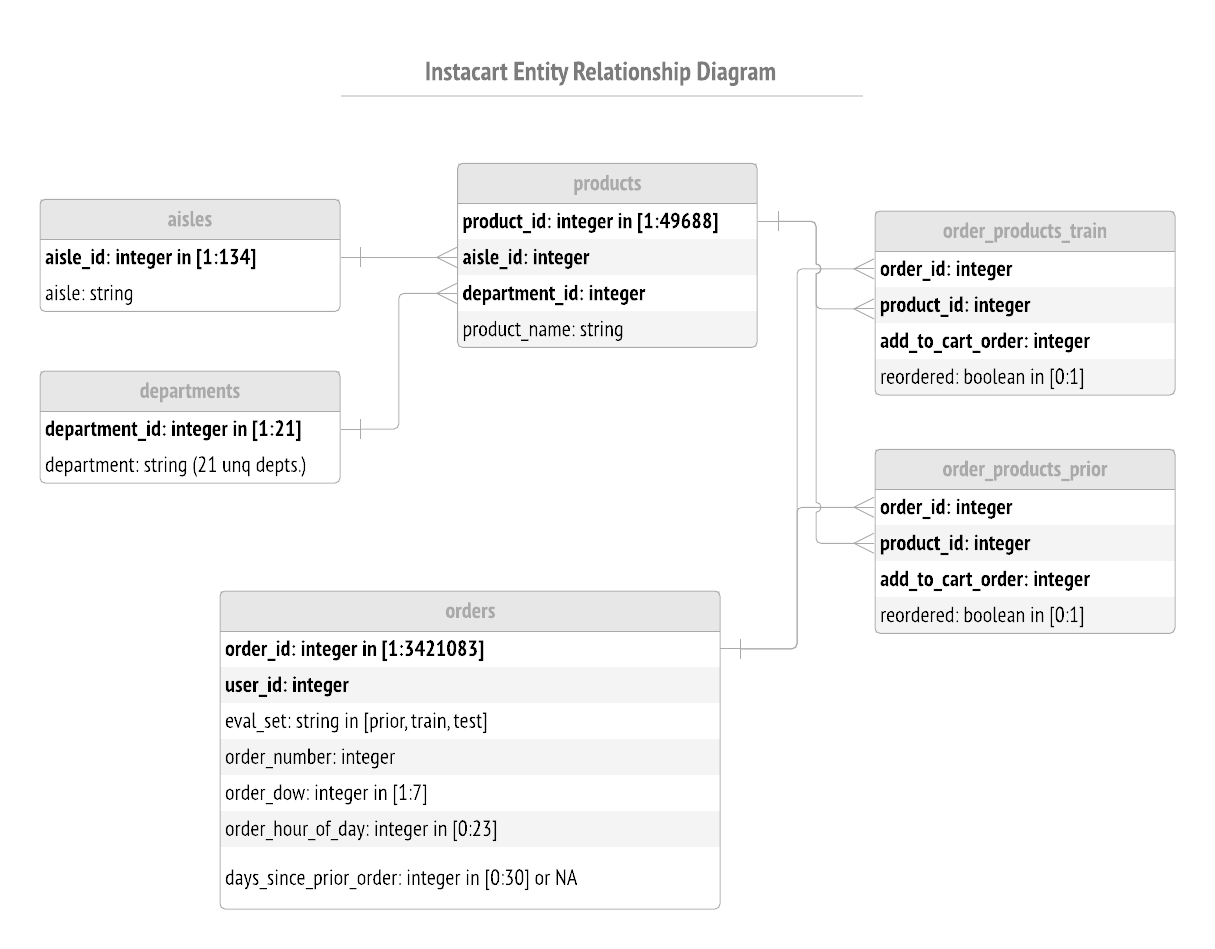

In [11]:
Image(filename = 'images/Instacart ERD.png')

#### Data Visualization
**Order Historgrams**

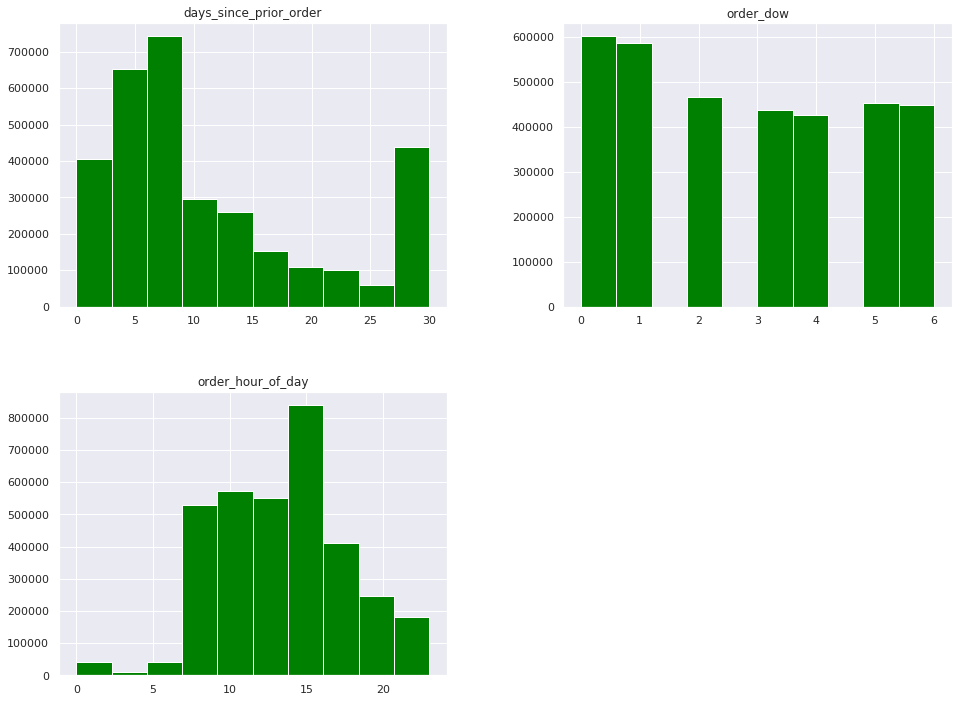

In [12]:
sns.set()
orders_df[['order_dow','order_hour_of_day','days_since_prior_order']].hist(figsize=(16,12), color='green')
plt.show()

**Days Since Prior Order**: Most customers order products within 7 days of their previous order.  
**Order Hour of Day**: Most customers place an order between 3 and 6pm.  
**Order Day of Week**: Most customers order on Sunday and Monday, but not by much.

Now let's examine the orders table to understand how the data is split on the eval_set attribute.  First, let's examine the total count of records within the order table.

In [13]:
print(orders_df['eval_set'].value_counts().sum())

3421083


Let's compare the three classes for the eval_set attribute (prior, test, train)

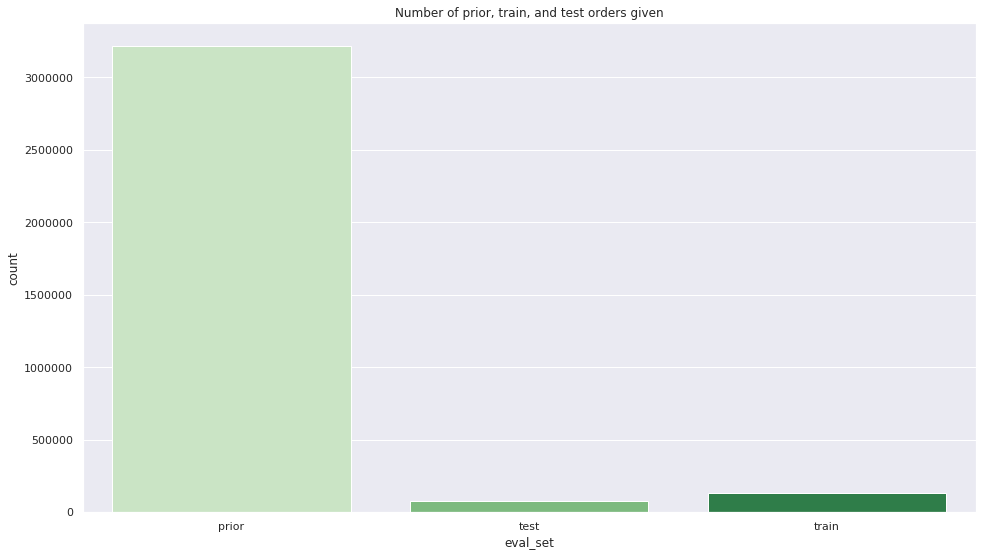

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


In [14]:
plt.figure(figsize=(16,9))
sns.countplot(x='eval_set', data=orders_df, palette='Greens')
plt.title('Number of prior, train, and test orders given')
plt.show()

print(orders_df['eval_set'].value_counts())

The majority of orders are previous orders, and the test, train sets are fairly small in comparison.  How many unique users are in the orders table?

In [15]:
print('Total Unique Users:', max(orders_df['user_id'].unique()))

Total Unique Users: 206209


There are 206,209 unique users in the orders table.  Of these orders, 75,000 are in the test set and 131,209 are in the train set.  
Now, lets examine the number of orders by 'order_dow','order_hour_of_day',and 'days_since_prior_order'.  

#### Orders By Day of Week

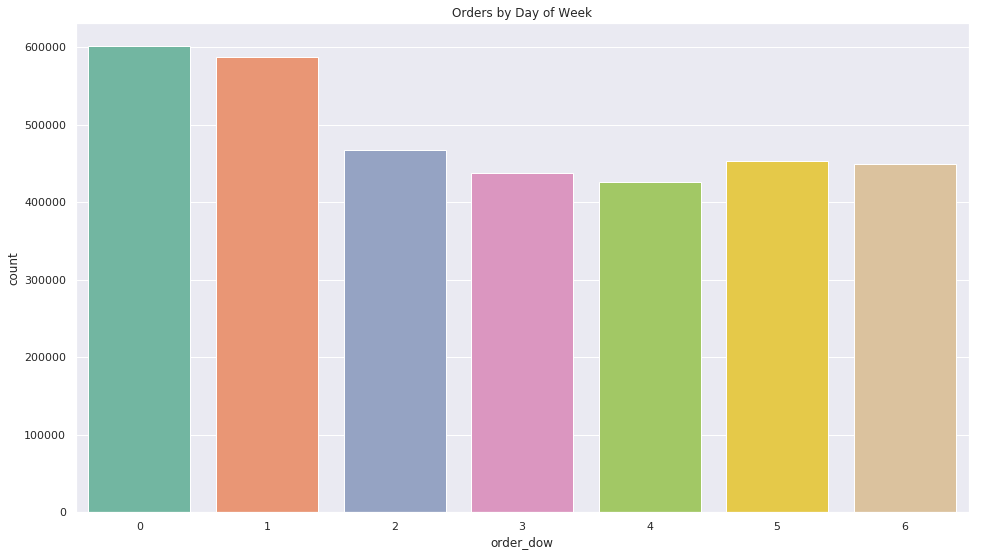

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64


In [16]:
# Compare orders per day of the week 
plt.figure(figsize=(16,9))
sns.countplot(x='order_dow', data=orders_df, palette='Set2')
plt.title('Orders by Day of Week')
plt.show()
# print the values
print(orders_df['order_dow'].value_counts())

#### Orders By Hour of Day

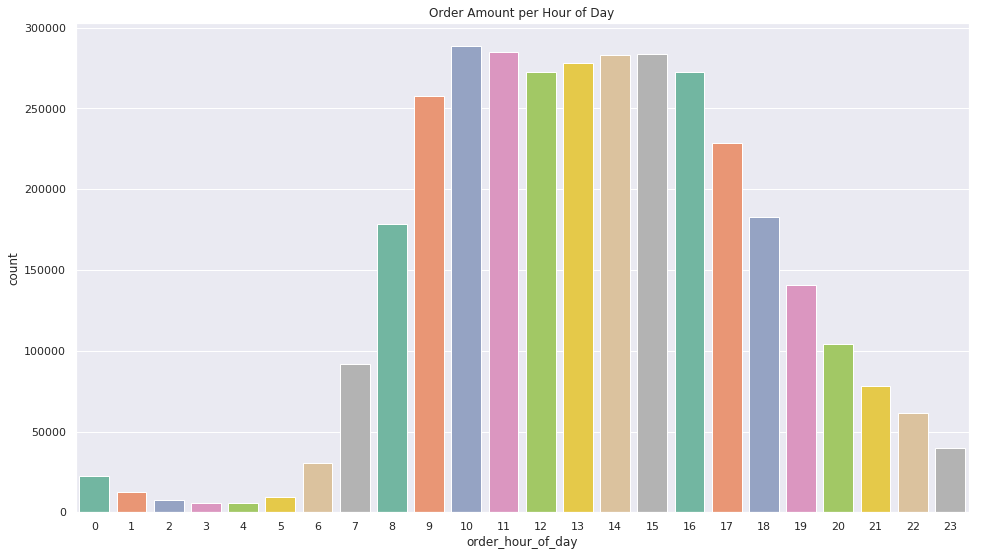

10    288418
11    284728
15    283639
14    283042
13    277999
12    272841
16    272553
9     257812
17    228795
18    182912
8     178201
19    140569
20    104292
7      91868
21     78109
22     61468
23     40043
6      30529
0      22758
1      12398
5       9569
2       7539
4       5527
3       5474
Name: order_hour_of_day, dtype: int64


In [17]:
# Compare orders per hour of day
plt.figure(figsize=(16,9))
sns.countplot(x='order_hour_of_day', data=orders_df, palette='Set2')
plt.title('Order Amount per Hour of Day')
plt.show()
# print the values
print(orders_df['order_hour_of_day'].value_counts())

#### Days Since Last Order

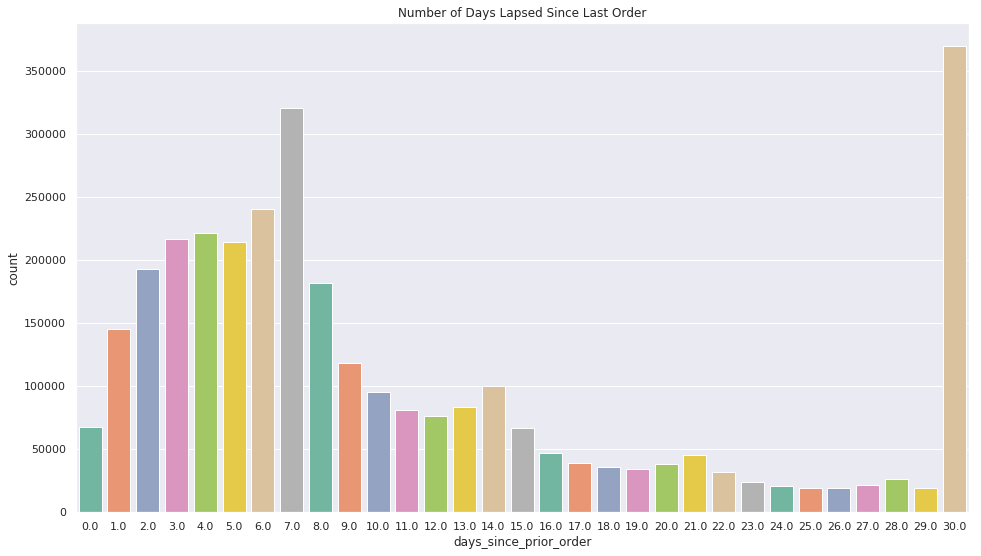

In [18]:
# Order intervals 
plt.figure(figsize=(16,9))
sns.countplot(x='days_since_prior_order', data=orders_df, palette='Set2')
plt.title('Number of Days Lapsed Since Last Order')
plt.show()

It's interesting that there are two spikes in the Days since last order for users.  The 7th and 30th (last day of the month) seem to have most orders on these two days.  


In [19]:
# merge to get product name and order information in the same table 
order_products_prior = pd.merge(priors_df, products_df, on='product_id', how='left')
# inspect
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


Now that we have merged the two tables, let's examine the frequency counts for most and least favored products.

#### Most and Least Popular Products Sold

**Top 20 Products Sold**

In [20]:
popular_products_df = order_products_prior['product_name'].value_counts().reset_index().head(49688)
popular_products_df.columns = ['product_name', 'count']
popular_products_df.head(20)

,product_name,count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


**Least Popular Products Sold**

In [21]:
popular_products_df.tail(20)

,product_name,count
49657,'Swingtop' Premium Lager,1
49658,"Sleep Aid, Calms Forte, Tablets",1
49659,Orange Flavored Ice Cubes,1
49660,Master Blend Coffee,1
49661,Dried Porcini Mushroom,1
49662,"Salsa, Black Bean",1
49663,Lndbrg White Quinoa 16 Z,1
49664,Hennepin Farmhouse Ale,1
49665,Cinnamon Rice Pudding Snacks,1
49666,Chardonnay Carneros,1


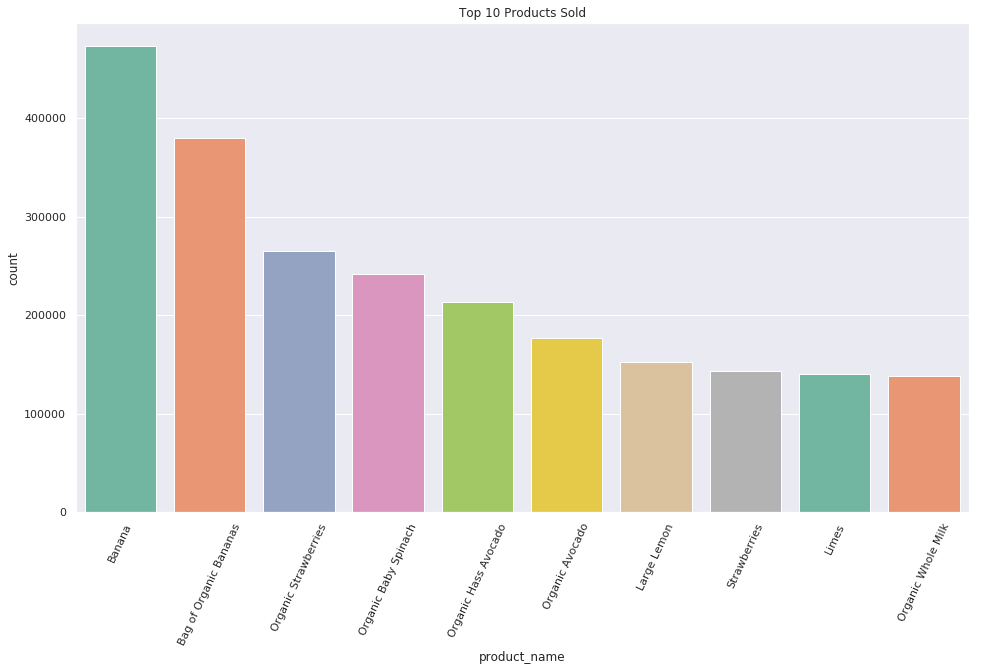

In [24]:
top_10_products_df = order_products_prior['product_name'].value_counts().reset_index().head(10)
top_10_products_df.columns = ['product_name', 'count']
plt.figure(figsize=(16,9))
sns.barplot(x='product_name', y='count', data=top_10_products_df, palette='Set2')
plt.title('Top 10 Products Sold')
plt.xticks(rotation=65)
plt.show()

Instacart prides itself on delivering fresh produce, and the marketing effort behind this shows.  The majority of Instacart purchases include produce, and of these fruits, vegetables and dairy products, Bananas (Organic or not!) are the most popular product sold by a long shot. **Now That's Just Simply Bananas!**

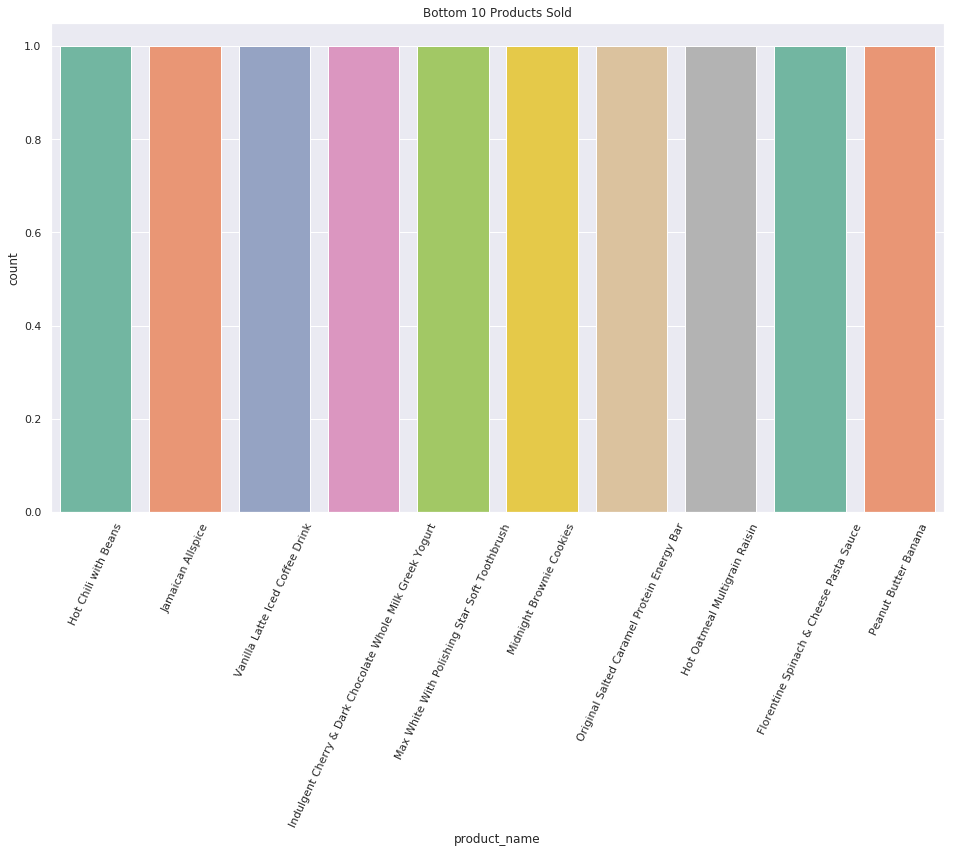

In [25]:
bottom_10_products_df = order_products_prior['product_name'].value_counts().reset_index().tail(10)
bottom_10_products_df.columns = ['product_name', 'count']
plt.figure(figsize=(16,9))
sns.barplot(x='product_name', y='count', data=bottom_10_products_df, palette='Set2')
plt.title('Bottom 10 Products Sold')
plt.xticks(rotation=65)
plt.show()

It is interesting that the least favorite product also includes Banana!